# EATS PL Report - Telescopes
Template by André Moitinho

***

### Student number: 61424
### Name: Luís Leitão

***

<div class="alert alert-block alert-info">

## Instructions

* Fill in your name and number above
* This template provides blocks of instructions that guide you through the activity and report. Put your codes and comments below the corresponding blocks. 
* Add as many code and markdown cells as necessary. 
* The blue background colour in the markdown cells (like this one) is reserved for the instruction blocks. Use white cells for your comments.
* Write a clear report:
    * Provide justifications and comments.
    * Figures and labels (legends, axes, etc) should be easy to read.
    * Tables should be neatly formatted and include labels.

**To submit your report:**

You will need to have the nbconvert[webpdf] package installed for saving to pdf. <br>
Anaconda: conda install -c conda-forge nbconvert-webpdf <br>
General: pip install nbconvert[webpdf]
    
* Clean up and make sure all works well: In the "Kernel" menu select "Restart & Run All" (or use the "fast forward/double arrow" icon). Wait until the process is completed
* Save to a pdf file:
    * JupyterNotebook users: In the "File" menu -> "Download As" -> "**PDF via HTML (.html)**". 
    * JupyterLab users: In the "File" menu -> "Save and Export Notebook As" -> "**Webpdf**".
* Check that the PDF file is fine (no truncated lines, nothing missing, etc)
* Name the file: NumberFirstnameLastname.pdf* (e.g. 10101ClaudeShannon.pdf)
* Upload the pdf file to the "PL Report - Telescopes" assignement area. 

### Tips
* Run a cell  - keyboard shortcut: shift-enter
* To create "markdown" cells like this one, For comments, not for code: create a new cell. In the menu above to the right of the "fast-forward" icon there's a dropdown button with the default value "Code". Change to "Markdown".
* To display an image from a file on disk (e.g. image.png): In a **markdown cell** you can use *\!\[some text\](image.png)*, or simply drag and drop!
</div>

---

<div class="alert alert-block alert-info">  

## Setup
Put all your imports (e.g. numpy,matplotlib, etc)  in the cell bellow
</div>


In [39]:
from pathlib import Path

#pandas
import os
import pandas as pd


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Astropy
# The tools in ccdproc accept only CCDData objects
from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy.modeling import models
from astropy.io import fits

#ccdproc
import ccdproc as ccdp
from ccdproc import ImageFileCollection

import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info">
    
## <center>PART 1 -  KNOWING YOUR DATA</center>

    
### Basic image information
    
For the set of fits files in the *0_mainData* folder, create a table with: image_name, filter exposure_time, imagetype, object_name.  Show:
* the command line you used for this 
* the table (use the “pandas” package and display the column names at the top)
</div>


In [2]:
# Remember: Add code/markdown cells as needed (delete this line in your report)
folder_path = Path('0_mainData') 
images = ImageFileCollection(folder_path)
file_list = os.listdir(folder_path)
object = []
imagetype = []
filter = []
exptime = []

for filename in file_list:
    file_path = os.path.join(folder_path, filename)
    hdu = fits.open(file_path)

    filter.append(hdu[0].header['FILTER'])
    exptime.append(hdu[0].header['EXPTIME'])
    imagetype.append(hdu[0].header['IMAGETYP'])
    object.append(hdu[0].header['OBJECT'])

data = {
    "File": file_list,
    "Filter": filter,
    "Exptime": exptime,
    "Image_type": imagetype,
    "Object": object,
}

maindata = pd.DataFrame(data)
maindata  

file_list

['3241o.fits',
 '3249o.fits',
 '3262o.fits',
 '3265o.fits',
 '4015b.fits',
 '4016b.fits',
 '4017b.fits',
 '4075f.fits',
 '4076f.fits',
 '4078f.fits',
 '4079f.fits',
 '4080f.fits',
 '4081f.fits',
 '4082f.fits',
 '4083f.fits',
 '4084f.fits',
 '4085f.fits',
 '4086f.fits',
 '4087f.fits']

<div class="alert alert-block alert-info">

### Determine the CCD gain and readout noise:
    
For this, follow the recipe given in Howell p.71-73.
    
In the *gainNoise* folder, use images bias1, bias2, domeV1 and domeV2 to determine the readout noise and gain of the CCD. Don't forget to select an appropriate section of the image for the calculations (don’t use the overscan section).  
Update the CCD header of your images with the values you have just determined.
    
Verify in one image header that the values have indeed been updated. 

* Show the updated header

    



</div>


In [3]:
## Set-up the image files
read_path = Path('0_mainData')
image_files = ImageFileCollection(read_path)

read_path_gn = Path('gainNoise')
image_files_gn = ImageFileCollection(read_path_gn)

## Set-up path to write processed files
write_path = Path('ProcGainNoise')
write_path.mkdir(exist_ok=True)



In [4]:
## Subtract overscan, trim overscand and borders, and compute average 
mean_values = []
files_OT = []
for ccd, file_name in image_files_gn.ccds(ccd_kwargs={'unit': 'adu'}, return_fname=True):
    # Subtract the overscan
    ccd = ccdp.subtract_overscan(ccd, fits_section='[1030:1068,:]', median=True, overscan_axis=1)
    # Trim the overscan and borders
    ccd = ccdp.trim_image(ccd, fits_section='[10:1024, 10:1024]')
    # Save average values to array
    mean_values.append(float(np.asarray(ccd.mean())))
    # Save processed files
    ccd.write(str(write_path)+'/OT_'+file_name, overwrite=True) 
    # Save file names to array 
    files_OT.append('/OT_'+file_name)  
    
B1_mean = mean_values[0]
B2_mean = mean_values[1]
F1_mean = mean_values[2]
F2_mean = mean_values[3]

In [5]:
# Subtract bias and flats
hdu_bias1 = fits.open(str(write_path)+'/'+files_OT[0])
hdu_bias2 = fits.open(str(write_path)+'/'+files_OT[1])
hdu_flat1 = fits.open(str(write_path)+'/'+files_OT[2])
hdu_flat2 = fits.open(str(write_path)+'/'+files_OT[3])

data_bias1 = hdu_bias1[0].data
data_bias2 = hdu_bias2[0].data
data_flat1 = hdu_flat1[0].data
data_flat2 = hdu_flat2[0].data

b1_2 = data_bias1 - data_bias2
f1_2 = data_flat1 - data_flat2

#Standard deviations
sigma_b = np.std(b1_2)
sigma_f = np.std(f1_2)

#Gain and noise calculations
gain = (F1_mean+F2_mean-B1_mean-B2_mean)/(sigma_f**2-sigma_b**2)
read_noise = gain*sigma_b/np.sqrt(2)

#Round values
rgain = round(gain,2)
rread_noise = round(read_noise,2)


print('Gain = ', rgain)
print('Readout Noise = ', rread_noise)



Gain =  1.28
Readout Noise =  6.32


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1015                                                  
NAXIS2  =                 1015                                                  
ORIGIN  = 'Copyright (C) 1991-1998 GKR Computer Consulting' / FITS file originat
DATE    = '2001-06-05T23:49:49' / Date FITS file was generated                  
IRAF-TLM= '15:49:49 (05/06/2001)' / Time of last modification                   
EXPTIME =                    1                                                  
FILTER  = 'UNKNOWN '                                                            
IMAGETYP= 'BIAS    '                                                            
CCDSUM  = '1 1     '                                                            
CCDSEC  = '[1:1024,1:1024]' 

In [29]:
#Update headers with the determined gain and RN

for file in maindata['File']:
    with fits.open(str(read_path)+'/'+file, mode='update') as hdu:
        # Modify header
        hdu[0].header['GAIN'] = rgain
        hdu[0].header['RDNOISE'] = rread_noise
        hdu.flush()
    



#Para imagens da gainnoise
"""
hdu_bias1[0].header['GAIN'] = rgain
hdu_bias1[0].header['RDNOISE'] = rread_noise

hdu_bias2[0].header['GAIN'] = rgain
hdu_bias2[0].header['RDNOISE'] = rread_noise

hdu_flat1[0].header['GAIN'] = rgain
hdu_flat1[0].header['RDNOISE'] = rread_noise

hdu_flat2[0].header['GAIN'] = rgain
hdu_flat2[0].header['RDNOISE'] = rread_noise

"""

#Show new header

hdu_show = fits.open(str(read_path)+'/'+maindata['File'][0])
hdu_show[0].header
#hdu_bias1.info()


SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1072 / Axis length                                    
NAXIS2  =                 1024 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'Copyright (C) 1991-1998 GKR Computer Consulting' / FITS file originat
DATE    = '2001-06-06T00:19:27' / Date FITS file was generated                  
IRAF-TLM= '15:49:40 (05/06/2001)' / Time of last modification                   
EXPTIME =                    5                                                  
FILTER  = 'I       '        

<div class="alert alert-block alert-info">
   
### Tracking the bias level - I
    
Display one of the bias images in DS9. Remember, they are also called “zero” images. You can identify them by checking the list created above.

In the “scale” menu on the top bar, uncheck the “use DATASEC” option. You will now be able to also see the overscan strip. 
    
Interactively, roughly estimate by eye the mean level of the data section and of the overscan section (explore the pixel table and smooth tools offered in the “analysis” menu on the top bar). 
    
* What values do you estimate?
* Show a snapshot of your desktop with the DS9 main window and the auxiliary tools panel(s) used in this analysis.

</div>


Data section mean level ~ 450

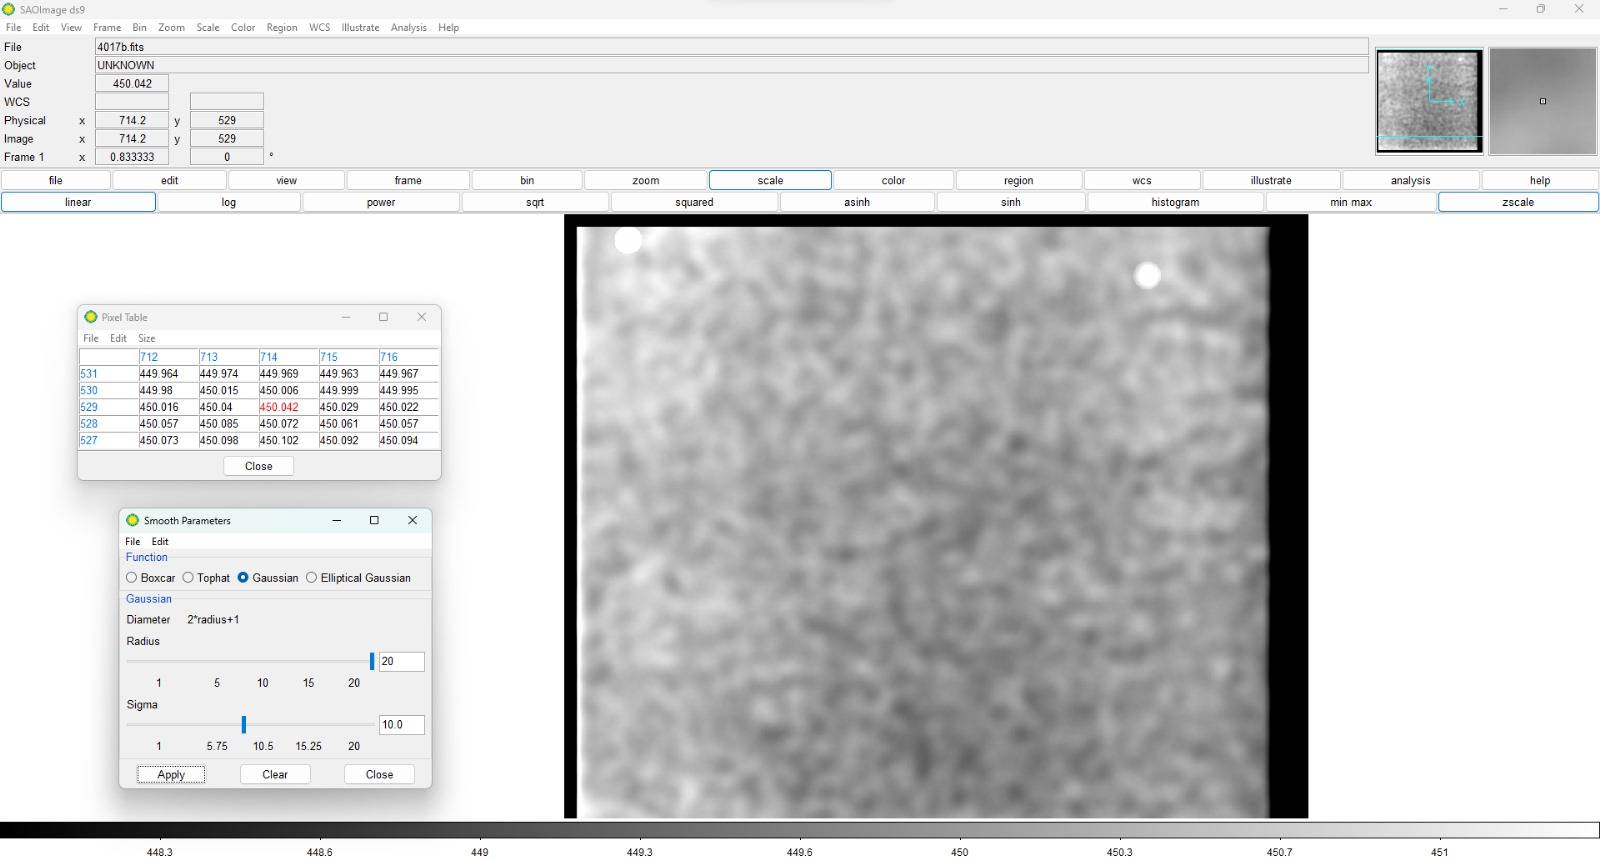

Overscan section mean level ~ 400

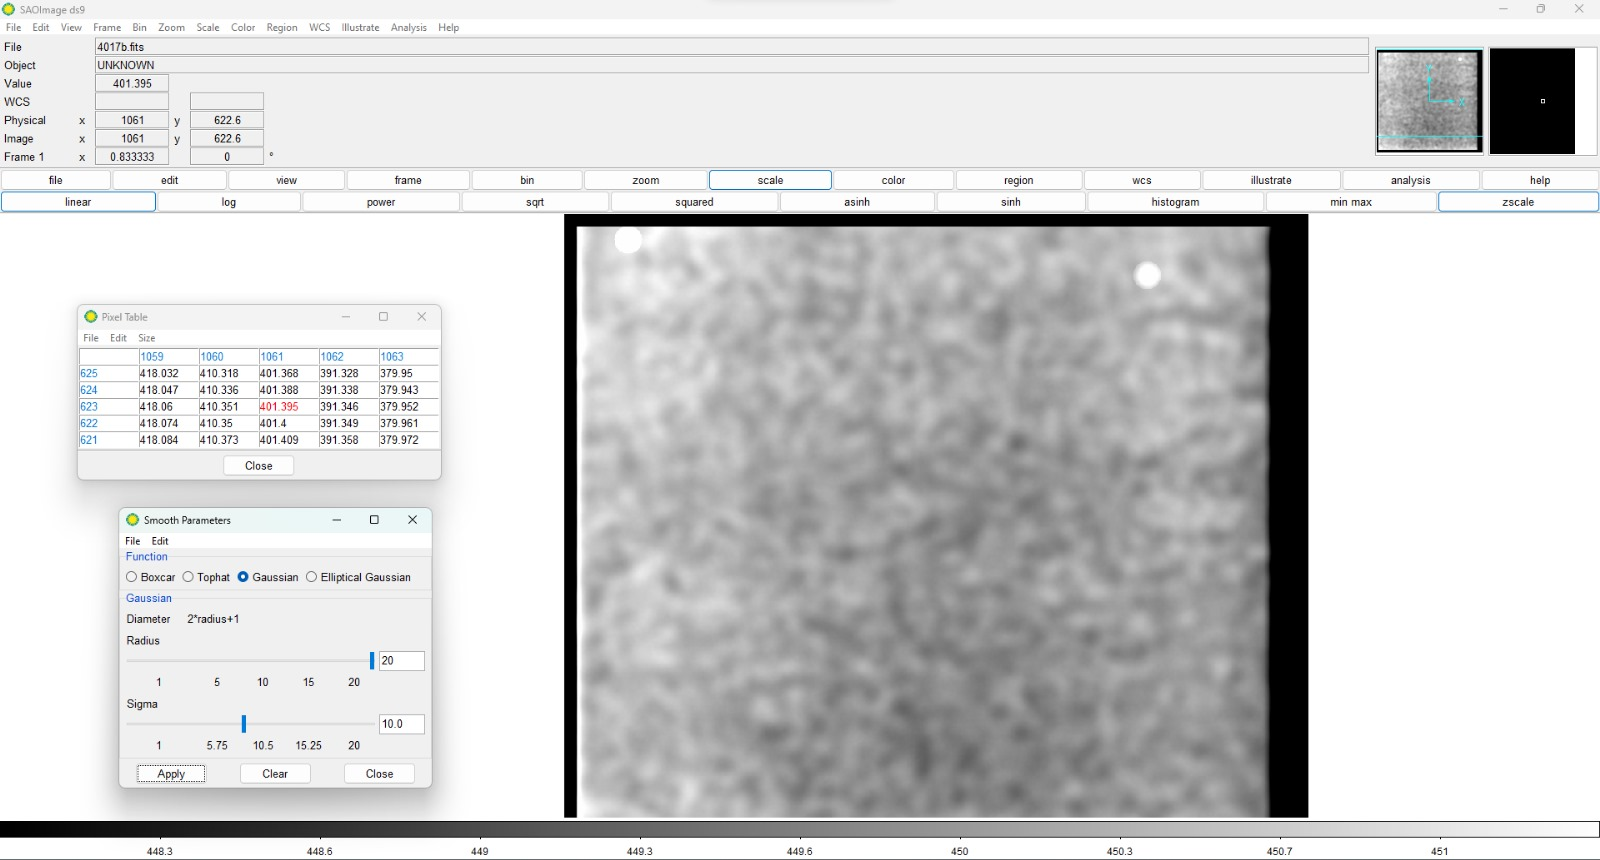

<div class="alert alert-block alert-info">

### Tracking the bias level - II
    
Now, from to the *superbias* folder. Consider appropriate sections (avoid obvious defects) of all images to compute the necessary statistics for:
* Making a scatter plot with x= image number (e.g. 5239 for image 5239o.fits) and y= mean bias level
* Making a scatter plot with x= image number and y= mean bias - mean overscan
* Place both plots side-by-side in a same figure
* What do you conclude?

Because the bias images are approximately uniform, the standard deviation of the counts in a small box (e.g. 5x5 or 10x10 pixels) give an idea of the read out noise (here in ADUs, not electrons).  From one of your bias images, compute the typical standard deviation in the Data Section and in the Overscan Section. Take 3 boxes spread out each of these sections to estimate the typical values.
* What do you conclude?


    
</div>


In [31]:
# Set-up superbias files' path
superbias_path = Path('superbias')

In [35]:
# Image colection
superbias_img = ImageFileCollection(superbias_path)

# Arrays for image nr and mean bias level values
image_nr = []
mean_bias_level_raw = []
mean_bias_level_over = []

for ccd, file_name in superbias_img.ccds(ccd_kwargs={'unit':'adu'}, return_fname=True):
    # Subtract overscan
    ccd_over = ccdp.subtract_overscan(ccd, fits_section='[1030:1068,:]', median=True, overscan_axis=1)
    # Trim subtracted overscan to center 100x100
    ccd_over = ccdp.trim_image(ccd_over, fits_section='[20:1020, 20:1020]')
    ## Save overscan subtracted mean bias level
    mean_bias_level_over.append(float(np.asarray(ccd_over.mean())))

    ## Trim raw image to center 100x100
    ccd_raw = ccdp.trim_image(ccd, fits_section='[20:1020, 20:1020]')
    ## Save raw image mean bias level to array
    mean_bias_level_raw.append(float(np.asarray(ccd_raw.mean())))
    ## Save image nr to array
    image_nr.append(int(file_name.split('b')[0]))

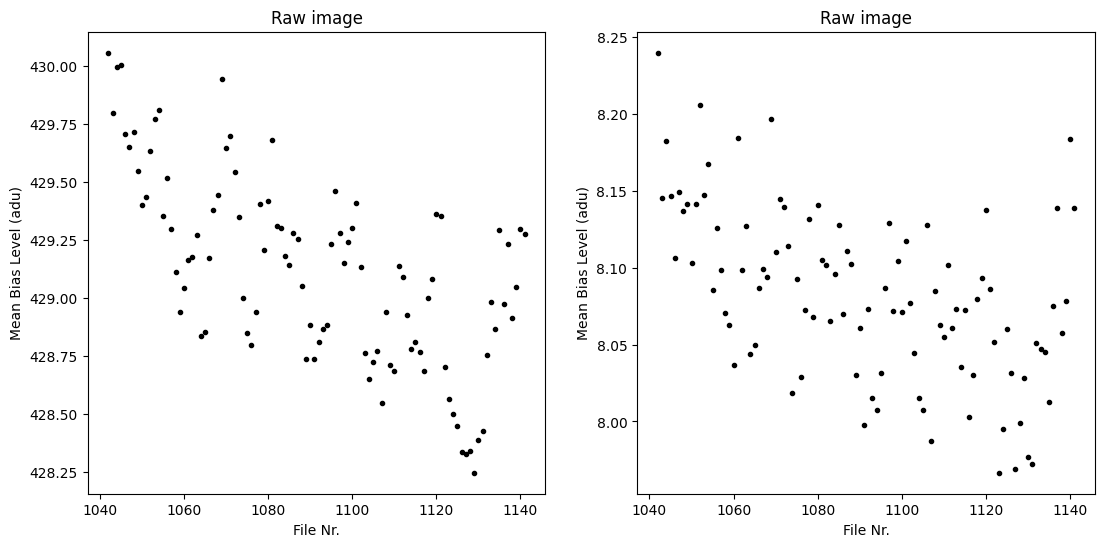

In [51]:
# Scatter plot mean bias level vs image nr
fig,ax = plt.subplots(1,2,figsize=(13,6))

ax[0].scatter(image_nr,mean_bias_level_raw,marker = '.', color = 'black') 
ax[0].set_xlabel('File Nr.')
ax[0].set_ylabel('Mean Bias Level (adu)')
ax[0].set_title('Raw image')

ax[1].scatter(image_nr,mean_bias_level_over,marker = '.', color = 'black') 
ax[1].set_xlabel('File Nr.')
ax[1].set_ylabel('Mean Bias Level (adu)')
ax[1].set_title('Raw image')
plt.show()

<div class="alert alert-block alert-info">

## <center> PART 2 - DATA PROCESSING </center>


### Overscan and Trim

Select appropriate overscan and trim areas. 
* Justify your selection. 

Apply the overscan correction and trim all the images. in the *0_mainData* folder. Save the processed images in another folder (e.g. 1_processed). 

Verify that the images have been processed:
* Show the header of one of the newly corrected images.
* Present a table showing that all images have been processed.


</div>


<div class="alert alert-block alert-info">

### Creating the Bias correction image

From the *superbias* folder, apply the overscan correction and trim all the 100 images.

Combine them to create the master bias correction image (we’ll refer to it as the superZero image). 
* Explain your choices for the image combination (combine method, parameters, etc)

Estimate the typical mean level and standard deviation (noise) of the superZero image.
* How does it compare with the values from any of the individual images used to produce it? Why?
* Display a picture of superZero.    

</div>


<div class="alert alert-block alert-info">

### Bias correction

In the processed folder, use the superZero image to apply the bias correction to the images that should be corrected. Make sure a keyword to was added to flag that the images have been bias subtracted.

Verify that the images have been processed:
* Show the header of one of the newly corrected images.
* Present a table showing that all images have been processed.    

</div>


<div class="alert alert-block alert-info">

### Creating the flatfield correction images

Create the flatfield correction images for both filters. Use the task default parameters. What problem did you find? Fix it! 
* How did you fix the problem? (NOTE: take care not to use the combined flat images you've created in the previous attempt when generating the new good ones)
* Show the good and the bad flatfield correction images you have created. Identify the images clearly with labels.     

</div>


<div class="alert alert-block alert-info">

### Flatfield correction

Apply the flatfield correction to the object images. 
Verify that the images have been processed:
* Show the header of one of the newly corrected images.
* Present a table showing that all images have been processed.    

</div>


<div class="alert alert-block alert-info">
    
You did it! The final science images are ready for delivery to the client. You have processed and removed the detector footprint down to the percent level.
* Display the 4 final  corrected images. Identify each images clearly with labels 

</div>
